# A non-linear Naghdi roll-up cantilever

In [1]:
import numpy as np
from mpi4py import MPI
from petsc4py import PETSc
import dolfinx
import ufl
from basix.ufl import blocked_element, element, enriched_element, mixed_element
from dolfinx.fem import Function, functionspace, dirichletbc, Expression, locate_dofs_topological, Constant
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.mesh import CellType, create_rectangle, locate_entities_boundary, meshtags
from ufl import grad, inner, split
from dolfinx import plot, default_scalar_type
from dolfinx.nls.petsc import NewtonSolver
from tqdm import tqdm
import pyvista

# Simulation setup

In [2]:
nex = int(48)
ney = int(4)

ele_type = "qua" 
#ele_type = "tri" 
#ele_type = "tri_enriched"

if ele_type == "tri_enriched":
    cell_type = CellType.triangle
    enriched = True
elif ele_type == "tri":
    cell_type = CellType.triangle
    enriched = False
elif ele_type == "qua":
    cell_type = CellType.quadrilateral

In [3]:
from pathlib import Path

results_folder = Path(f"results/nonlinear_Naghdi/roll-up_cantilever/{nex}_{ney}_{ele_type}")
results_folder.mkdir(exist_ok=True, parents=True)

pyvista.start_xvfb()

# Mesh

In [4]:
length = 12.0
width = 1.0

mesh = create_rectangle(MPI.COMM_WORLD, np.array([[0.0, -width/2.0], [length, width/2.0]]), 
                        [nex, ney], cell_type)
tdim = mesh.topology.dim
fdim = tdim - 1

## Plot mesh

In [5]:
topology, cell_types, geometry = plot.vtk_mesh(mesh, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

plotter = pyvista.Plotter(off_screen = True)
plotter.add_mesh(grid, show_edges=True)
plotter.show_grid()
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    plotter.screenshot(results_folder/f"mesh_rank{mesh.comm.rank}.png")

plotter.close()

Widget(value='<iframe src="http://localhost:38119/index.html?ui=P_0x7f5f5c5b21e0_0&reconnect=auto" class="pyvi…

# Material

In [5]:
E, nu = Constant(mesh, default_scalar_type(1.2E6)), Constant(mesh, default_scalar_type(0.0))
mu = E/(2.0*(1.0 + nu))
lmbda = 2.0*mu*nu/(1.0 - 2.0*nu)
t = Constant(mesh, default_scalar_type(1E-1))

# Initial shape

In [6]:
x = ufl.SpatialCoordinate(mesh)
phi0_ufl = ufl.as_vector([x[0], x[1], 0])

def unit_normal(phi):
    n = ufl.cross(phi.dx(0), phi.dx(1))
    return n/ufl.sqrt(inner(n, n))


n0_ufl = unit_normal(phi0_ufl)

# for the 3 translation DOFs, we use the P2 + B3 enriched element
cell = mesh.basix_cell()
P2 = element("Lagrange", cell, degree=2)
B3 = element("Bubble", cell, degree=3)

def tangent_1(n):
    e2 = ufl.as_vector([0, 1, 0])
    t1 = ufl.cross(e2, n)
    t1 = t1/ufl.sqrt(inner(t1, t1))
    return t1

def tangent_2(n, t1):
    t2 = ufl.cross(n, t1)
    t2 = t2/ufl.sqrt(inner(t2, t2))
    return t2

# the analytical expression of t1 and t2
t1_ufl = tangent_1(n0_ufl)
t2_ufl = tangent_2(n0_ufl, t1_ufl)

# the analytical expression of R0
def rotation_matrix(t1, t2, n):
    R = ufl.as_matrix([[t1[0], t2[0], n[0]], 
                       [t1[1], t2[1], n[1]], 
                       [t1[2], t2[2], n[2]]])
    return R

R0_ufl = rotation_matrix(t1_ufl, t2_ufl, n0_ufl)
# Update the director with two successive elementary rotations

def director(R0, theta):
    Lm3 = ufl.as_vector([ufl.sin(theta[1])*ufl.cos(theta[0]), -ufl.sin(theta[0]), ufl.cos(theta[1])*ufl.cos(theta[0])])
    d = ufl.dot(R0, Lm3)
    return d

## plot initial shape

In [8]:
# create a FEM interpolation of n0 and phi0
P1_d3_FS = functionspace(mesh, element("Lagrange", cell, degree = 1, shape = (3,)))

n0_P1_expr = Expression(n0_ufl, P1_d3_FS.element.interpolation_points())
n0_P1_func = Function(P1_d3_FS)
n0_P1_func.interpolate(n0_P1_expr)

phi0_P1_expr = Expression(phi0_ufl, P1_d3_FS.element.interpolation_points())
phi0_P1_func = Function(P1_d3_FS)
phi0_P1_func.interpolate(phi0_P1_expr)

In [9]:
topology, cell_types, geometry = plot.vtk_mesh(P1_d3_FS)

geometry_phi0_P1 = phi0_P1_func.x.array.reshape((geometry.shape[0], len(phi0_P1_func)))
geometry_n0_P1 = n0_P1_func.x.array.reshape((geometry.shape[0], len(n0_P1_func)))

grid_phi0_P1 = pyvista.UnstructuredGrid(topology, cell_types, geometry_phi0_P1)
grid_phi0_P1["n0"] = geometry_n0_P1
glyphs = grid_phi0_P1.glyph(orient="n0", factor=0.2)


plotter = pyvista.Plotter(off_screen = True)
plotter.add_mesh(grid_phi0_P1, style="wireframe", color="k")
plotter.add_mesh(glyphs,  show_scalar_bar=True, scalar_bar_args={"vertical": True})
plotter.show_grid()
plotter.enable_parallel_projection()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    plotter.screenshot(results_folder/f"initial_shape_rank{mesh.comm.rank}.png")
    
plotter.close()

Widget(value='<iframe src="http://localhost:40879/index.html?ui=P_0x7f34101171d0_0&reconnect=auto" class="pyvi…

# Shell element

In [7]:
if ele_type == "tri_enriched":
    P2B3 = enriched_element([P2, B3])
    naghdi_shell_element = mixed_element(
        [blocked_element(P2B3, shape=(3,)), blocked_element(P2, shape=(2,))]
    )
elif ele_type == "tri":
        naghdi_shell_element = mixed_element(
            [blocked_element(P2, shape=(3,)), blocked_element(P2, shape=(2,))]
        )
    
elif ele_type == "qua":
    naghdi_shell_element = mixed_element(
        [blocked_element(P2, shape=(3,)), blocked_element(P2, shape=(2,))]
    )
    
naghdi_shell_FS = functionspace(mesh, naghdi_shell_element)

q_func = Function(naghdi_shell_FS) # current configuration
q_trial = ufl.TrialFunction(naghdi_shell_FS)
q_test = ufl.TestFunction(naghdi_shell_FS)

u_func, theta_func = split(q_func) # current displacement and rotation

# Shell model

In [8]:
# current deformation gradient 
F = grad(u_func) + grad(phi0_ufl) 

# current director
d = director(R0_ufl, theta_func)

# initial metric and curvature tensor a0 and b0
a0_ufl = grad(phi0_ufl).T * grad(phi0_ufl)
b0_ufl = -0.5*( grad(phi0_ufl).T * grad(n0_ufl) + grad(n0_ufl).T * grad(phi0_ufl))

def epsilon(F):
    """Membrane strain"""
    return 0.5 * (F.T * F - a0_ufl)


def kappa(F, d):
    """Bending strain"""
    return -0.5 * (F.T * grad(d) + grad(d).T * F) - b0_ufl


def gamma(F, d):
    """Transverse shear strain"""
    return F.T * d

a0_contra_ufl = ufl.inv(a0_ufl)
j0_ufl = ufl.det(a0_ufl)

i,j,l,m = ufl.indices(4)  # noqa: E741
A_contra_ufl = ufl.as_tensor( ( ((2.0*lmbda*mu) / (lmbda + 2.0*mu)) * a0_contra_ufl[i,j]*a0_contra_ufl[l,m]
                + 1.0*mu* (a0_contra_ufl[i,l]*a0_contra_ufl[j,m] + a0_contra_ufl[i,m]*a0_contra_ufl[j,l]) )
                ,[i,j,l,m])

N = ufl.as_tensor(t * A_contra_ufl[i,j,l,m] * epsilon(F)[l,m], [i,j])

M = ufl.as_tensor( (t**3 / 12.0) * A_contra_ufl[i,j,l,m]*kappa(F, d)[l,m], [i,j])

T = ufl.as_tensor( (t * mu *5.0 / 6.0) * a0_contra_ufl[i, j] * gamma(F, d)[j], [i])

psi_m = 0.5*inner(N, epsilon(F))

psi_b = 0.5*inner(M, kappa(F, d))

psi_s = 0.5*inner(T, gamma(F, d))

# External work

In [9]:
def left(x):
    return np.isclose(x[0], 0)


def right(x):
    return np.isclose(x[0], length)

left_facets = locate_entities_boundary(mesh, fdim, left)
right_facets = locate_entities_boundary(mesh, fdim, right)

# left facets are marked with tag 1, right facets are marked with tag 2
marked_facets = np.hstack([left_facets, right_facets])
marked_values = np.hstack([np.full_like(left_facets, 1), np.full_like(right_facets, 2)])
sorted_facets = np.argsort(marked_facets)
facet_tag = meshtags(mesh, fdim, marked_facets[sorted_facets], marked_values[sorted_facets])

M_right = Constant(mesh, default_scalar_type(0.0))

ds = ufl.Measure("ds", domain=mesh, subdomain_data=facet_tag, metadata={"quadrature_degree": 2})

W_ext = M_right * theta_func[1] * ds(2)

# Potential energy with PSRI

In [10]:
# Full integration of order 4
dx_f = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 4})

# Reduced integration of order 2
dx_r = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 2})

# Calculate the factor alpha as a function of the mesh size h
h = ufl.CellDiameter(mesh)
alpha_FS = functionspace(mesh, element("DG", cell, 0))
alpha_expr = Expression(t**2 / h**2, alpha_FS.element.interpolation_points())
alpha = Function(alpha_FS)
alpha.interpolate(alpha_expr)

# Full integration part of the total elastic energy
Pi_PSRI = psi_b * ufl.sqrt(j0_ufl) * dx_f 
Pi_PSRI += alpha * psi_m * ufl.sqrt(j0_ufl) * dx_f
Pi_PSRI += alpha * psi_s * ufl.sqrt(j0_ufl) * dx_f

# Reduced integration part of the total elastic energy
Pi_PSRI += (1.0 - alpha) * psi_m * ufl.sqrt(j0_ufl) * dx_r
Pi_PSRI += (1.0 - alpha) * psi_s * ufl.sqrt(j0_ufl) * dx_r

# external work part
Pi_PSRI -= W_ext

Residual = ufl.derivative(Pi_PSRI, q_func, q_test)
Jacobian = ufl.derivative(Residual, q_func, q_trial)

# clamped left boundary condtions

In [11]:
u_FS, _ = naghdi_shell_FS.sub(0).collapse()
theta_FS, _ = naghdi_shell_FS.sub(1).collapse()

# u1, u2, u3 = 0 on the clamped boundary
u_clamped = Function(u_FS) # default value is 0
clamped_dofs_u = locate_dofs_topological((naghdi_shell_FS.sub(0), u_FS), fdim, facet_tag.find(1))
bc_clamped_u = dirichletbc(u_clamped, clamped_dofs_u, naghdi_shell_FS.sub(0))

# theta1, theta2 = 0 on the clamped boundary
theta_clamped = Function(theta_FS) # default value is 0
clamped_dofs_theta = locate_dofs_topological((naghdi_shell_FS.sub(1), theta_FS), fdim, facet_tag.find(1))
bc_clamped_theta = dirichletbc(theta_clamped, clamped_dofs_theta, naghdi_shell_FS.sub(1))

bcs = [bc_clamped_u, bc_clamped_theta]

# BB tree

In [12]:

bb_tree = dolfinx.geometry.bb_tree(mesh, 2)
bb_point = np.array([[length, 0.0, 0.0]], dtype=np.float64)

# Find the leaf that the target point is in
bb_cell_candidates = dolfinx.geometry.compute_collisions_points(bb_tree, bb_point)

# Find the cell from the leaf that contains the target point
bb_cells = dolfinx.geometry.compute_colliding_cells(
    mesh, bb_cell_candidates, bb_point)

# Newton solver

In [13]:
problem = NonlinearProblem(Residual, q_func, bcs, Jacobian)
solver = NewtonSolver(mesh.comm, problem)

# Set Newton solver options
solver.rtol = 1e-6
solver.atol = 1e-6
solver.max_it = 100
solver.convergence_criterion = "incremental"
solver.report = True

# Modify the linear solver in each Newton iteration
ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "preonly"
#opts[f"{option_prefix}ksp_type"] = "cg"
opts[f"{option_prefix}pc_type"] = "lu"
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
ksp.setFromOptions()

In [14]:
M_max = 2.0*np.pi*E.value*t.value**3/(12.0*length)
nstep = 125
Ms = np.linspace(0.0, M_max, nstep)

if mesh.comm.rank == 0:
    u1_list = np.zeros(nstep)
    u3_list = np.zeros(nstep)
    
file_u = dolfinx.io.VTKFile(mesh.comm, results_folder/"u.pvd", "w")
file_theta = dolfinx.io.VTKFile(mesh.comm, results_folder/"theta.pvd", "w")
file_phi = dolfinx.io.VTKFile(mesh.comm, results_folder/"phi.pvd", "w")
 
q_func.x.array[:] = 0.0

for i, M_curr in enumerate(tqdm(Ms)):
    M_right.value = M_curr
    n, converged = solver.solve(q_func)
    assert (converged)
    q_func.x.scatter_forward()
    if mesh.comm.rank == 0:
        print(f"Load step {i:d}, Number of iterations: {n:d}, Load: {M_curr:.2f} ({M_max:.2f})", flush=True)
    
    # write output
    phi_FS = functionspace(mesh, blocked_element(P2, shape=(3,)))
    if ele_type == "tri_enriched":
        u_P2B3 = q_func.sub(0).collapse()
        u_P2 = Function(phi_FS)
        u_P2.interpolate(u_P2B3)
    else:
        u_P2 = q_func.sub(0).collapse()
    
    phi_expr = Expression(phi0_ufl + u_P2, phi_FS.element.interpolation_points())
    phi_func = Function(phi_FS)
    phi_func.interpolate(phi_expr)
    theta_P2 = q_func.sub(1).collapse()

    file_u.write_function(u_P2, i)
    file_theta.write_function(theta_P2, i)
    file_phi.write_function(phi_func, i)
    
    # calculate u3 at the point load
    u1_bb = None
    u3_bb = None
    u1_func = q_func.sub(0).sub(0).collapse()
    u3_func = q_func.sub(0).sub(2).collapse()
    if len(bb_cells.array) > 0:
        u1_bb = u1_func.eval(bb_point, bb_cells.array[0])[0]
        u3_bb = u3_func.eval(bb_point, bb_cells.array[0])[0]
    u1_bb = mesh.comm.gather(u1_bb, root=0)
    u3_bb = mesh.comm.gather(u3_bb, root=0)
    if mesh.comm.rank == 0:
        for u1 in u1_bb:
            if u1 is not None:
                u1_list[i] = u1
                break
            
        for u3 in u3_bb:
            if u3 is not None:
                u3_list[i] = u3
                break
file_u.close()
file_theta.close()
file_phi.close()

  0%|          | 0/125 [00:00<?, ?it/s]

Load step 0, Number of iterations: 2, Load: 0.00 (52.36)


  1%|          | 1/125 [00:00<00:22,  5.62it/s]

Load step 1, Number of iterations: 5, Load: 0.42 (52.36)


  2%|▏         | 2/125 [00:00<00:34,  3.57it/s]

Load step 2, Number of iterations: 5, Load: 0.84 (52.36)


  2%|▏         | 3/125 [00:00<00:36,  3.32it/s]

Load step 3, Number of iterations: 5, Load: 1.27 (52.36)


  3%|▎         | 4/125 [00:01<00:38,  3.10it/s]

Load step 4, Number of iterations: 5, Load: 1.69 (52.36)


  4%|▍         | 5/125 [00:01<00:38,  3.13it/s]

Load step 5, Number of iterations: 5, Load: 2.11 (52.36)


  5%|▍         | 6/125 [00:01<00:42,  2.78it/s]

Load step 6, Number of iterations: 5, Load: 2.53 (52.36)


  6%|▌         | 7/125 [00:02<00:40,  2.89it/s]

Load step 7, Number of iterations: 5, Load: 2.96 (52.36)


  6%|▋         | 8/125 [00:02<00:42,  2.75it/s]

Load step 8, Number of iterations: 5, Load: 3.38 (52.36)


  7%|▋         | 9/125 [00:03<00:41,  2.79it/s]

Load step 9, Number of iterations: 5, Load: 3.80 (52.36)


  8%|▊         | 10/125 [00:03<00:40,  2.84it/s]

Load step 10, Number of iterations: 5, Load: 4.22 (52.36)


  9%|▉         | 11/125 [00:03<00:39,  2.90it/s]

Load step 11, Number of iterations: 5, Load: 4.64 (52.36)


 10%|▉         | 12/125 [00:04<00:43,  2.60it/s]

Load step 12, Number of iterations: 5, Load: 5.07 (52.36)


 10%|█         | 13/125 [00:04<00:41,  2.72it/s]

Load step 13, Number of iterations: 5, Load: 5.49 (52.36)


 11%|█         | 14/125 [00:04<00:40,  2.71it/s]

Load step 14, Number of iterations: 5, Load: 5.91 (52.36)


 12%|█▏        | 15/125 [00:05<00:38,  2.88it/s]

Load step 15, Number of iterations: 5, Load: 6.33 (52.36)


 13%|█▎        | 16/125 [00:05<00:38,  2.83it/s]

Load step 16, Number of iterations: 5, Load: 6.76 (52.36)


 14%|█▎        | 17/125 [00:05<00:38,  2.79it/s]

Load step 17, Number of iterations: 5, Load: 7.18 (52.36)


 14%|█▍        | 18/125 [00:06<00:40,  2.66it/s]

Load step 18, Number of iterations: 5, Load: 7.60 (52.36)


 15%|█▌        | 19/125 [00:06<00:40,  2.64it/s]

Load step 19, Number of iterations: 5, Load: 8.02 (52.36)


 16%|█▌        | 20/125 [00:07<00:40,  2.57it/s]

Load step 20, Number of iterations: 5, Load: 8.45 (52.36)


 17%|█▋        | 21/125 [00:07<00:44,  2.34it/s]

Load step 21, Number of iterations: 5, Load: 8.87 (52.36)


 18%|█▊        | 22/125 [00:07<00:40,  2.52it/s]

Load step 22, Number of iterations: 5, Load: 9.29 (52.36)


 18%|█▊        | 23/125 [00:08<00:38,  2.67it/s]

Load step 23, Number of iterations: 5, Load: 9.71 (52.36)


 19%|█▉        | 24/125 [00:08<00:39,  2.56it/s]

Load step 24, Number of iterations: 5, Load: 10.13 (52.36)


 20%|██        | 25/125 [00:09<00:37,  2.65it/s]

Load step 25, Number of iterations: 5, Load: 10.56 (52.36)


 21%|██        | 26/125 [00:09<00:36,  2.74it/s]

Load step 26, Number of iterations: 5, Load: 10.98 (52.36)


 22%|██▏       | 27/125 [00:09<00:34,  2.83it/s]

Load step 27, Number of iterations: 5, Load: 11.40 (52.36)


 22%|██▏       | 28/125 [00:10<00:34,  2.81it/s]

Load step 28, Number of iterations: 5, Load: 11.82 (52.36)


 23%|██▎       | 29/125 [00:10<00:33,  2.85it/s]

Load step 29, Number of iterations: 5, Load: 12.25 (52.36)


 24%|██▍       | 30/125 [00:10<00:31,  3.02it/s]

Load step 30, Number of iterations: 5, Load: 12.67 (52.36)


 25%|██▍       | 31/125 [00:11<00:30,  3.07it/s]

Load step 31, Number of iterations: 5, Load: 13.09 (52.36)


 26%|██▌       | 32/125 [00:11<00:31,  2.96it/s]

Load step 32, Number of iterations: 5, Load: 13.51 (52.36)


 26%|██▋       | 33/125 [00:11<00:30,  3.04it/s]

Load step 33, Number of iterations: 5, Load: 13.93 (52.36)


 27%|██▋       | 34/125 [00:12<00:29,  3.06it/s]

Load step 34, Number of iterations: 5, Load: 14.36 (52.36)


 28%|██▊       | 35/125 [00:12<00:31,  2.83it/s]

Load step 35, Number of iterations: 5, Load: 14.78 (52.36)


 29%|██▉       | 36/125 [00:12<00:31,  2.83it/s]

Load step 36, Number of iterations: 5, Load: 15.20 (52.36)


 30%|██▉       | 37/125 [00:13<00:31,  2.77it/s]

Load step 37, Number of iterations: 5, Load: 15.62 (52.36)


 30%|███       | 38/125 [00:13<00:29,  2.93it/s]

Load step 38, Number of iterations: 5, Load: 16.05 (52.36)


 31%|███       | 39/125 [00:13<00:31,  2.75it/s]

Load step 39, Number of iterations: 5, Load: 16.47 (52.36)


 32%|███▏      | 40/125 [00:14<00:30,  2.76it/s]

Load step 40, Number of iterations: 5, Load: 16.89 (52.36)


 33%|███▎      | 41/125 [00:14<00:30,  2.72it/s]

Load step 41, Number of iterations: 5, Load: 17.31 (52.36)


 34%|███▎      | 42/125 [00:15<00:34,  2.38it/s]

Load step 42, Number of iterations: 5, Load: 17.73 (52.36)


 34%|███▍      | 43/125 [00:15<00:40,  2.04it/s]

Load step 43, Number of iterations: 5, Load: 18.16 (52.36)


 35%|███▌      | 44/125 [00:16<00:38,  2.09it/s]

Load step 44, Number of iterations: 5, Load: 18.58 (52.36)


 36%|███▌      | 45/125 [00:16<00:36,  2.22it/s]

Load step 45, Number of iterations: 5, Load: 19.00 (52.36)


 37%|███▋      | 46/125 [00:17<00:34,  2.27it/s]

Load step 46, Number of iterations: 5, Load: 19.42 (52.36)


 38%|███▊      | 47/125 [00:17<00:32,  2.41it/s]

Load step 47, Number of iterations: 5, Load: 19.85 (52.36)


 38%|███▊      | 48/125 [00:17<00:30,  2.55it/s]

Load step 48, Number of iterations: 5, Load: 20.27 (52.36)


 39%|███▉      | 49/125 [00:18<00:27,  2.74it/s]

Load step 49, Number of iterations: 5, Load: 20.69 (52.36)


 40%|████      | 50/125 [00:18<00:26,  2.83it/s]

Load step 50, Number of iterations: 5, Load: 21.11 (52.36)


 41%|████      | 51/125 [00:18<00:25,  2.93it/s]

Load step 51, Number of iterations: 5, Load: 21.54 (52.36)


 42%|████▏     | 52/125 [00:19<00:25,  2.83it/s]

Load step 52, Number of iterations: 5, Load: 21.96 (52.36)


 42%|████▏     | 53/125 [00:19<00:24,  2.92it/s]

Load step 53, Number of iterations: 5, Load: 22.38 (52.36)


 43%|████▎     | 54/125 [00:19<00:23,  3.00it/s]

Load step 54, Number of iterations: 5, Load: 22.80 (52.36)


 44%|████▍     | 55/125 [00:20<00:24,  2.90it/s]

Load step 55, Number of iterations: 5, Load: 23.22 (52.36)


 45%|████▍     | 56/125 [00:20<00:22,  3.03it/s]

Load step 56, Number of iterations: 5, Load: 23.65 (52.36)


 46%|████▌     | 57/125 [00:20<00:22,  3.06it/s]

Load step 57, Number of iterations: 5, Load: 24.07 (52.36)


 46%|████▋     | 58/125 [00:21<00:22,  3.02it/s]

Load step 58, Number of iterations: 5, Load: 24.49 (52.36)


 47%|████▋     | 59/125 [00:21<00:22,  2.93it/s]

Load step 59, Number of iterations: 5, Load: 24.91 (52.36)


 48%|████▊     | 60/125 [00:21<00:21,  3.09it/s]

Load step 60, Number of iterations: 5, Load: 25.34 (52.36)


 49%|████▉     | 61/125 [00:22<00:23,  2.72it/s]

Load step 61, Number of iterations: 5, Load: 25.76 (52.36)


 50%|████▉     | 62/125 [00:22<00:27,  2.32it/s]

Load step 62, Number of iterations: 5, Load: 26.18 (52.36)


 50%|█████     | 63/125 [00:23<00:25,  2.42it/s]

Load step 63, Number of iterations: 5, Load: 26.60 (52.36)


 51%|█████     | 64/125 [00:23<00:24,  2.46it/s]

Load step 64, Number of iterations: 5, Load: 27.02 (52.36)


 52%|█████▏    | 65/125 [00:23<00:23,  2.57it/s]

Load step 65, Number of iterations: 5, Load: 27.45 (52.36)


 53%|█████▎    | 66/125 [00:24<00:22,  2.63it/s]

Load step 66, Number of iterations: 5, Load: 27.87 (52.36)


 54%|█████▎    | 67/125 [00:24<00:20,  2.79it/s]

Load step 67, Number of iterations: 5, Load: 28.29 (52.36)


 54%|█████▍    | 68/125 [00:24<00:20,  2.73it/s]

Load step 68, Number of iterations: 5, Load: 28.71 (52.36)


 55%|█████▌    | 69/125 [00:25<00:19,  2.80it/s]

Load step 69, Number of iterations: 5, Load: 29.14 (52.36)


 56%|█████▌    | 70/125 [00:25<00:19,  2.82it/s]

Load step 70, Number of iterations: 5, Load: 29.56 (52.36)


 57%|█████▋    | 71/125 [00:26<00:20,  2.67it/s]

Load step 71, Number of iterations: 5, Load: 29.98 (52.36)


 58%|█████▊    | 72/125 [00:26<00:18,  2.81it/s]

Load step 72, Number of iterations: 5, Load: 30.40 (52.36)


 58%|█████▊    | 73/125 [00:26<00:18,  2.80it/s]

Load step 73, Number of iterations: 5, Load: 30.82 (52.36)


 59%|█████▉    | 74/125 [00:27<00:17,  2.85it/s]

Load step 74, Number of iterations: 5, Load: 31.25 (52.36)


 60%|██████    | 75/125 [00:27<00:17,  2.92it/s]

Load step 75, Number of iterations: 5, Load: 31.67 (52.36)


 61%|██████    | 76/125 [00:27<00:17,  2.80it/s]

Load step 76, Number of iterations: 5, Load: 32.09 (52.36)


 62%|██████▏   | 77/125 [00:28<00:17,  2.77it/s]

Load step 77, Number of iterations: 5, Load: 32.51 (52.36)


 62%|██████▏   | 78/125 [00:28<00:17,  2.72it/s]

Load step 78, Number of iterations: 5, Load: 32.94 (52.36)


 63%|██████▎   | 79/125 [00:28<00:16,  2.86it/s]

Load step 79, Number of iterations: 5, Load: 33.36 (52.36)


 64%|██████▍   | 80/125 [00:29<00:16,  2.68it/s]

Load step 80, Number of iterations: 5, Load: 33.78 (52.36)


 65%|██████▍   | 81/125 [00:29<00:16,  2.70it/s]

Load step 81, Number of iterations: 5, Load: 34.20 (52.36)


 66%|██████▌   | 82/125 [00:29<00:15,  2.75it/s]

Load step 82, Number of iterations: 5, Load: 34.63 (52.36)


 66%|██████▋   | 83/125 [00:30<00:16,  2.61it/s]

Load step 83, Number of iterations: 5, Load: 35.05 (52.36)


 67%|██████▋   | 84/125 [00:30<00:15,  2.69it/s]

Load step 84, Number of iterations: 5, Load: 35.47 (52.36)


 68%|██████▊   | 85/125 [00:31<00:14,  2.68it/s]

Load step 85, Number of iterations: 5, Load: 35.89 (52.36)


 69%|██████▉   | 86/125 [00:31<00:14,  2.65it/s]

Load step 86, Number of iterations: 5, Load: 36.31 (52.36)


 70%|██████▉   | 87/125 [00:31<00:14,  2.70it/s]

Load step 87, Number of iterations: 5, Load: 36.74 (52.36)


 70%|███████   | 88/125 [00:32<00:14,  2.50it/s]

Load step 88, Number of iterations: 5, Load: 37.16 (52.36)


 71%|███████   | 89/125 [00:32<00:14,  2.55it/s]

Load step 89, Number of iterations: 5, Load: 37.58 (52.36)


 72%|███████▏  | 90/125 [00:33<00:14,  2.34it/s]

Load step 90, Number of iterations: 5, Load: 38.00 (52.36)


 73%|███████▎  | 91/125 [00:33<00:13,  2.51it/s]

Load step 91, Number of iterations: 5, Load: 38.43 (52.36)


 74%|███████▎  | 92/125 [00:33<00:12,  2.56it/s]

Load step 92, Number of iterations: 5, Load: 38.85 (52.36)


 74%|███████▍  | 93/125 [00:34<00:13,  2.46it/s]

Load step 93, Number of iterations: 5, Load: 39.27 (52.36)


 75%|███████▌  | 94/125 [00:34<00:12,  2.42it/s]

Load step 94, Number of iterations: 5, Load: 39.69 (52.36)


 76%|███████▌  | 95/125 [00:35<00:11,  2.51it/s]

Load step 95, Number of iterations: 5, Load: 40.11 (52.36)


 77%|███████▋  | 96/125 [00:35<00:11,  2.56it/s]

Load step 96, Number of iterations: 5, Load: 40.54 (52.36)


 78%|███████▊  | 97/125 [00:35<00:10,  2.64it/s]

Load step 97, Number of iterations: 5, Load: 40.96 (52.36)


 78%|███████▊  | 98/125 [00:36<00:10,  2.68it/s]

Load step 98, Number of iterations: 5, Load: 41.38 (52.36)


 79%|███████▉  | 99/125 [00:36<00:09,  2.73it/s]

Load step 99, Number of iterations: 5, Load: 41.80 (52.36)


 80%|████████  | 100/125 [00:37<00:10,  2.47it/s]

Load step 100, Number of iterations: 5, Load: 42.23 (52.36)


 81%|████████  | 101/125 [00:37<00:09,  2.48it/s]

Load step 101, Number of iterations: 5, Load: 42.65 (52.36)


 82%|████████▏ | 102/125 [00:37<00:09,  2.53it/s]

Load step 102, Number of iterations: 5, Load: 43.07 (52.36)


 82%|████████▏ | 103/125 [00:38<00:08,  2.50it/s]

Load step 103, Number of iterations: 5, Load: 43.49 (52.36)


 83%|████████▎ | 104/125 [00:38<00:08,  2.54it/s]

Load step 104, Number of iterations: 5, Load: 43.91 (52.36)


 84%|████████▍ | 105/125 [00:38<00:07,  2.74it/s]

Load step 105, Number of iterations: 5, Load: 44.34 (52.36)


 85%|████████▍ | 106/125 [00:39<00:06,  2.81it/s]

Load step 106, Number of iterations: 5, Load: 44.76 (52.36)


 86%|████████▌ | 107/125 [00:39<00:06,  2.80it/s]

Load step 107, Number of iterations: 5, Load: 45.18 (52.36)


 86%|████████▋ | 108/125 [00:40<00:06,  2.69it/s]

Load step 108, Number of iterations: 5, Load: 45.60 (52.36)


 87%|████████▋ | 109/125 [00:40<00:05,  2.78it/s]

Load step 109, Number of iterations: 5, Load: 46.03 (52.36)


 88%|████████▊ | 110/125 [00:40<00:05,  2.76it/s]

Load step 110, Number of iterations: 5, Load: 46.45 (52.36)


 89%|████████▉ | 111/125 [00:41<00:05,  2.71it/s]

Load step 111, Number of iterations: 5, Load: 46.87 (52.36)


 90%|████████▉ | 112/125 [00:41<00:04,  2.62it/s]

Load step 112, Number of iterations: 5, Load: 47.29 (52.36)


 90%|█████████ | 113/125 [00:41<00:04,  2.70it/s]

Load step 113, Number of iterations: 5, Load: 47.72 (52.36)


 91%|█████████ | 114/125 [00:42<00:04,  2.75it/s]

Load step 114, Number of iterations: 5, Load: 48.14 (52.36)


 92%|█████████▏| 115/125 [00:42<00:03,  2.91it/s]

Load step 115, Number of iterations: 5, Load: 48.56 (52.36)


 93%|█████████▎| 116/125 [00:42<00:03,  2.96it/s]

Load step 116, Number of iterations: 5, Load: 48.98 (52.36)


 94%|█████████▎| 117/125 [00:43<00:03,  2.54it/s]

Load step 117, Number of iterations: 5, Load: 49.40 (52.36)


 94%|█████████▍| 118/125 [00:43<00:02,  2.60it/s]

Load step 118, Number of iterations: 5, Load: 49.83 (52.36)


 95%|█████████▌| 119/125 [00:44<00:02,  2.64it/s]

Load step 119, Number of iterations: 5, Load: 50.25 (52.36)


 96%|█████████▌| 120/125 [00:44<00:01,  2.77it/s]

Load step 120, Number of iterations: 5, Load: 50.67 (52.36)


 97%|█████████▋| 121/125 [00:44<00:01,  2.72it/s]

Load step 121, Number of iterations: 5, Load: 51.09 (52.36)


 98%|█████████▊| 122/125 [00:45<00:01,  2.88it/s]

Load step 122, Number of iterations: 5, Load: 51.52 (52.36)


 98%|█████████▊| 123/125 [00:45<00:00,  2.85it/s]

Load step 123, Number of iterations: 5, Load: 51.94 (52.36)


 99%|█████████▉| 124/125 [00:45<00:00,  2.78it/s]

Load step 124, Number of iterations: 5, Load: 52.36 (52.36)


100%|██████████| 125/125 [00:46<00:00,  2.71it/s]


## plot deformed shape

In [ ]:
u_sol = q_func.sub(0).collapse()

phi_FS = functionspace(mesh, element("Lagrange", cell, degree = 2, shape = (3,)))
phi_expr = Expression(phi0_ufl + u_sol, phi_FS.element.interpolation_points())
phi_func = Function(phi_FS)
phi_func.interpolate(phi_expr)

topology, cell_types, geometry = plot.vtk_mesh(phi_FS)

geometry_phi = phi_func.x.array.reshape((geometry.shape[0], len(phi_func)))

grid_phi = pyvista.UnstructuredGrid(topology, cell_types, geometry_phi)

plotter = pyvista.Plotter()
plotter.add_mesh(grid_phi, show_edges=True)
plotter.show_grid()
plotter.enable_parallel_projection()
plotter.show_axes_all()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    plotter.screenshot(results_folder/"phi.png")
plotter.close()

## plot displacement versus moment

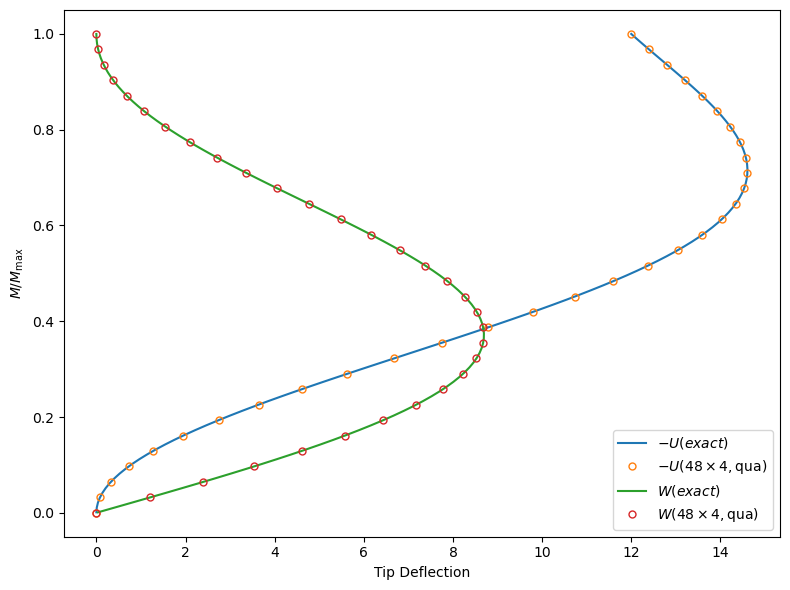

2024-04-15 18:22:57.032 ( 163.879s) [        884F0740]vtkOrientationMarkerWid:134    ERR| vtkOrientationMarkerWidget (0x560023374960): The interactor must be set prior to enabling/disabling widget


: 

In [16]:
import matplotlib.pyplot as plt

if mesh.comm.rank == 0:
    Ms_analytical = np.linspace(1E-3, 1.0, 100)
    us = 12.0*(np.sin(2.0*np.pi*Ms_analytical)/(2.0*np.pi*Ms_analytical) - 1.0)
    ws = -12.0*(1.0 - np.cos(2.0*np.pi*Ms_analytical))/(2.0*np.pi*Ms_analytical)
    np.savetxt(results_folder/"u1.txt", u1_list)
    np.savetxt(results_folder/"u3.txt", u3_list)
    np.savetxt(results_folder/"Ms_Mmax.txt", Ms/M_max)
    fig = plt.figure(figsize=(8.0, 6.0))
    plt.plot( -us, Ms_analytical, "-", label="$-U (exact)$")
    plt.plot( -u1_list, Ms/M_max, "o", markersize=5, markerfacecolor='none', markevery = 4, label=f"$-U ({nex}\\times{ney},${ele_type})")
    plt.plot( -ws, Ms_analytical, "-", label="$W (exact)$")
    plt.plot( -u3_list, Ms/M_max, "o", markersize=5, markerfacecolor='none', markevery = 4, label=f"$W ({nex}\\times{ney},${ele_type})")
    plt.ylabel(r"$M/M_{\mathrm{max}}$")
    plt.xlabel("Tip Deflection")
    plt.legend()
    plt.tight_layout()
    plt.savefig(results_folder/"comparisons.png", dpi=300)